In [28]:
import comet_ml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [29]:
comet_api = comet_ml.api.API()

In [30]:
exps = comet_api.get('federated-learning/server-side-opt')

In [31]:
clrs = [float(exp.get_parameters_summary('CLIENT_LEARNING_RATE')['valueMax']) for exp in exps]
slrs = [float(exp.get_parameters_summary('SERVER_LEARNING_RATE')['valueMax']) for exp in exps]
sopts = [exp.get_parameters_summary('SERVER_OPT')['valueMax'] for exp in exps]
teas = [float(exp.get_metrics_summary('test_acc')['valueMax']) for exp in exps]
ids = [exp.id for exp in exps]
groupnorm = ['groupnorm' in exp.get_tags() for exp in exps]

In [32]:
df = pd.DataFrame({'id': ids, 'groupnorm': groupnorm, 'client lr': clrs, 'server lr': slrs, 'server opt': sopts, 'test_acc': teas})
# df_fin = df[df['test_acc'] > 99]
# [float(d['metricValue']) for d in exp.get_metrics('test_acc')]

In [33]:
df.iloc[df.groupby(['server opt', 'server lr']).idxmax()['test_acc']]
# df.sort_values(['test_acc'], ascending=False)[['server lr', 'client lr', 'server opt', 'test_acc']]

,id,groupnorm,client lr,server lr,server opt,test_acc
25,cbaf1a4042f546579e53f123138d12cd,False,0.0001,0.001,Adagrad,15.49
32,b2c58af571eb4caa8eda54db60c5f155,False,0.0100,0.010,Adagrad,13.96
35,a2d483707d744cb48e912a476ef5bf50,False,0.0001,0.100,Adagrad,3.19
40,882da60cf74747ed8657c24ca4ec009f,False,0.0001,1.000,Adagrad,1.38
46,03b165faf048442e928f9089b981425f,False,0.0010,10.000,Adagrad,1.38
0,30106740743446ea9b4c1207ae3cc0ce,False,0.0001,0.001,Adam,20.84
7,6e311dff7e444eb882481e54694f5336,False,0.0100,0.010,Adam,6.11
12,801a237549964218bc439ca8051f9688,False,0.0100,0.100,Adam,1.77
16,003a5d4ac187442d83f0ac6e31cfb3db,False,0.0010,1.000,Adam,1.61
22,f565d7d81ce445059b8c212011b2bbbe,False,0.0100,10.000,Adam,1.48


In [34]:
df = df.sort_values(['server opt', 'server lr'])#[['server lr', 'client lr', 'server opt', 'test_acc']]

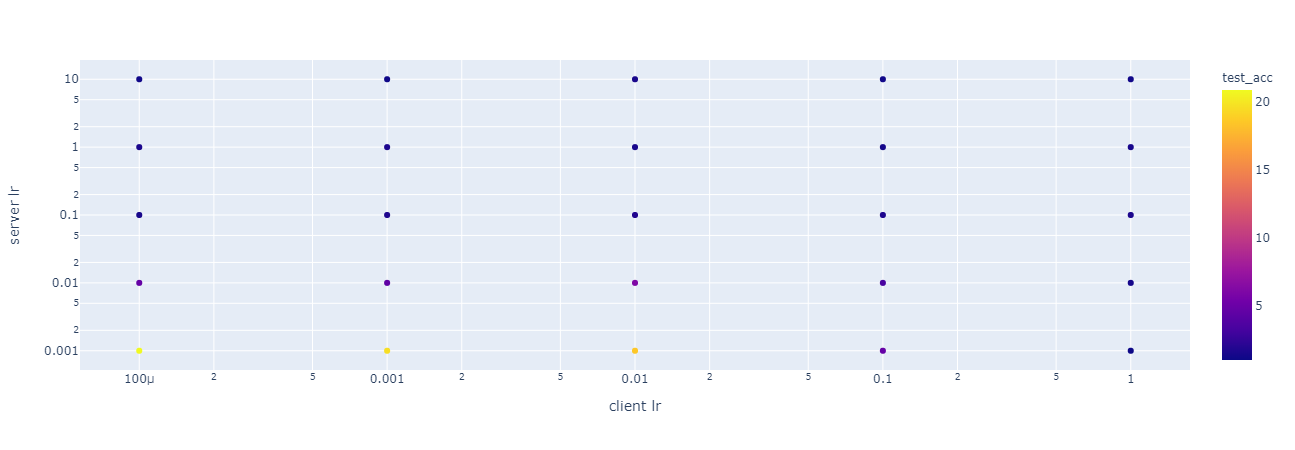

In [49]:
import plotly.express as px
import plotly.graph_objects as go
df_tmp = df[(df['server opt'] == 'Adam') & (df['groupnorm'] == False)]
import plotly.express as px
# df = px.data.gapminder()

fig = px.scatter(df_tmp, x="client lr", y="server lr", 
	         color="test_acc", log_x=True, log_y=True, size_max=60)
fig.show()
# fig = px.imshow(np.array(df_tmp['test_acc']).reshape((5,5)),
#                                 x=[str(s) for s in df_tmp['client lr'].unique()],
#                                 y=[str(s) for s in df_tmp['server lr'].unique()],
#          )
# fig.show()

In [67]:
[str(s) for s in df_tmp['client lr'].unique()]

['0.0001', '0.001', '0.01', '0.1', '1.0']

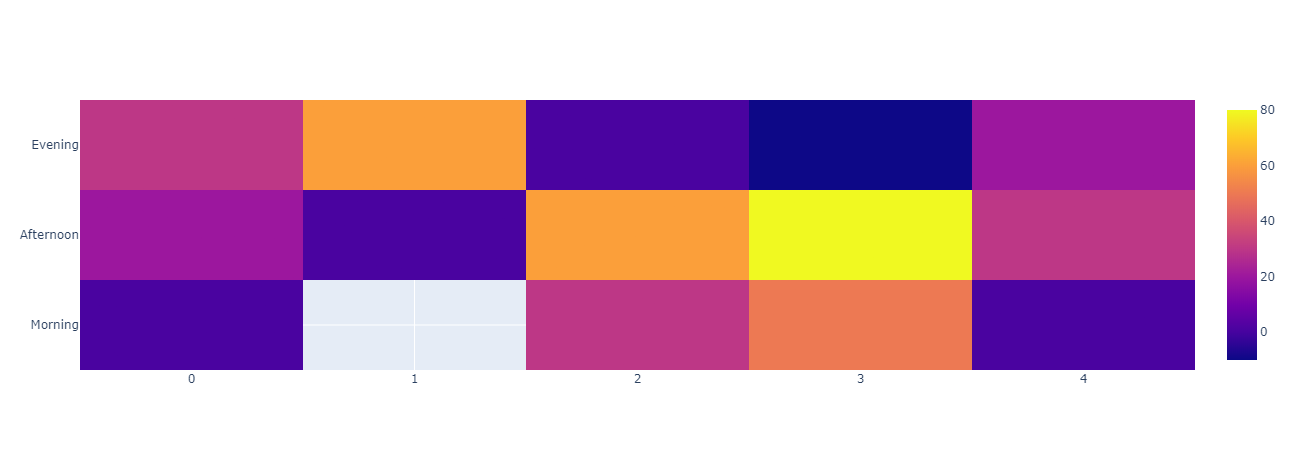

In [17]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=[[1, None, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, -10, 20]],
                   x=[f'{s}' for s in df_tmp['client lr'].unique()],#['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    xtype='scaled',
                   y=['Morning', 'Afternoon', 'Evening'],
                   hoverongaps = False))
fig.show()

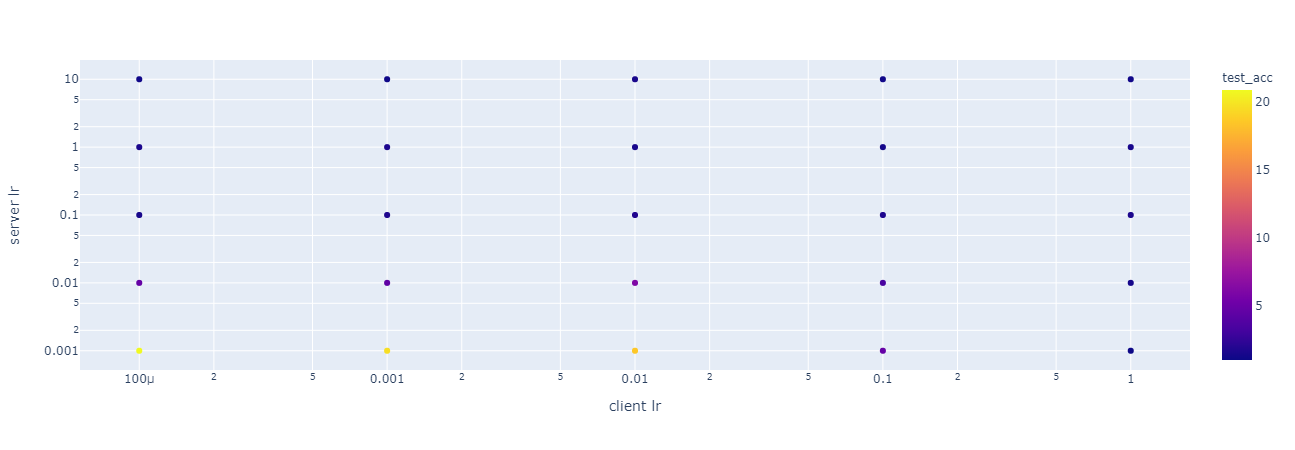

In [27]:
import plotly.express as px
# df = px.data.gapminder()

fig = px.scatter(df_tmp, x="client lr", y="server lr",
	         color="test_acc", log_x=True, log_y=True, size_max=60)
fig.show()

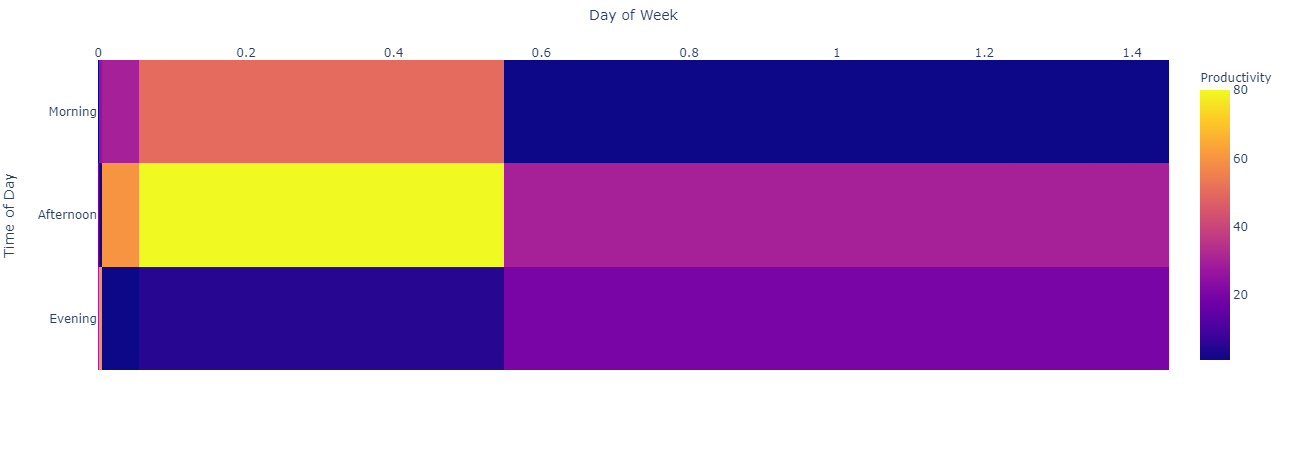

In [11]:
import plotly.express as px
data=[[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                x=[str(s) for s in df_tmp['client lr'].unique()],#['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                y=['Morning', 'Afternoon', 'Evening']
               )
fig.update_xaxes(side="top")
fig.show()

In [61]:
import plotly
plotly.__version__

'4.5.0'

In [ ]:
import comet_ml
import holoviews as hv
from typing import Tuple, List, Dict
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def plot_imgs(experiment, imgs, figure_name, step):
    plt.figure(figsize=(15, 15))
    gs1 = GridSpec(len(imgs), 1)
    gs1.update(wspace=0.0, hspace=0.0)  # set the spacing between axes.
    for fig_id, fig in enumerate(imgs):
        plt.subplot(gs1[fig_id])
        plt.axis('off')
        plt.imshow(fig)
    experiment.log_figure(figure_name=figure_name, step=step)
    plt.close('all')

def grid_plot_experiments(comet_api: comet_ml.API, experiments, p1_name: str, p2_name: str,
                          metrics: List[str] = ['train_acc', 'dev_acc', 'test_acc'], parameters: List[str] = [],
                          fig_size: int = 220) -> hv.core.layout.Layout:
    targets_data = _download_data(comet_api, experiments, p1_name, p2_name, metrics, parameters)

    layout = hv.Layout()
    for k, v in targets_data.items():
        layout += hv.HeatMap(v, kdims=[p1_name, p2_name], vdims=k).sort().opts(title=k, cmap='greens').redim.range(z=(0, None))
    return layout.opts(fig_size=fig_size, framewise=True)


def _download_data(comet_api: comet_ml.API, experiments, p1_name: str, p2_name: str, metrics: List[str],
                   parameters: List[str]) \
        -> Dict[str, List[Tuple[float, float, float]]]:
    targets_data = defaultdict(list)
    list2float = lambda l: float(l[0])
    for experiment in experiments:
        p1_value = list2float(comet_api.get_experiment_parameters(experiment.key, p1_name))
        p2_value = list2float(comet_api.get_experiment_parameters(experiment.key, p2_name))
        for parameter in parameters:
            target_data = list2float(comet_api.get_experiment_parameters(experiment.key, parameter))
            targets_data[parameter].append((p1_value, p2_value, target_data))
        for metric in metrics:
            target_data = list2float(comet_api.get_experiment_metrics(experiment.key, metric))
            targets_data[metric].append((p1_value, p2_value, target_data))
    return targets_data


In [ ]:
grid_plot_experiments(comet_api, exps, 'client lr', 'server lr')